# Import Required Libraries
Import the necessary libraries, including PyTorch, torchvision, and other required libraries.

In [1]:
# Import Required Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from PIL import Image
import cv2
import random

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
device

device(type='cuda', index=0)

# Load and Preprocess Data
Load the images from 'def_front' and 'ok_front' folders and preprocess them for training.

In [3]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

Dataset sizes: {'train': 265, 'val': 715}
Class names: ['def_front']


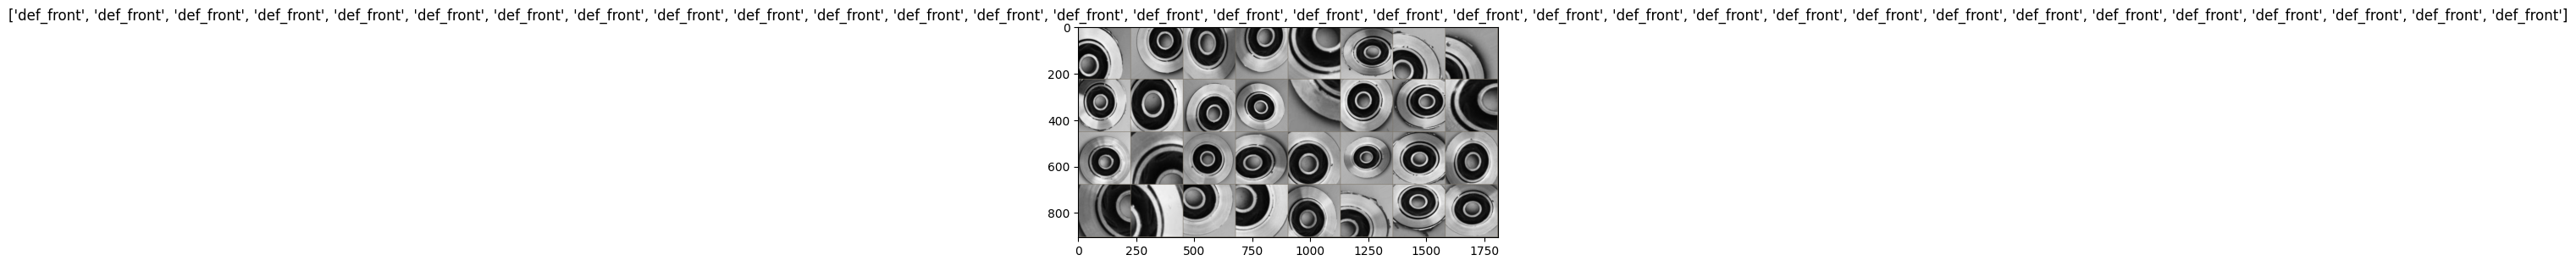

In [4]:
# Load and Preprocess Data

# Define data directories
# data_dir = 'casting_data\casting_data'
data_dir = os.path.join( 'data','casting_data', 'casting_data')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'test')

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

# Create data loaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Get class names
class_names = image_datasets['train'].classes

# Print dataset sizes and class names
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# Function to show a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Show images
imshow(out, title=[class_names[x] for x in classes])

# Data Augmentation
Apply data augmentation techniques such as random cropping, flipping, and rotation to the training data.

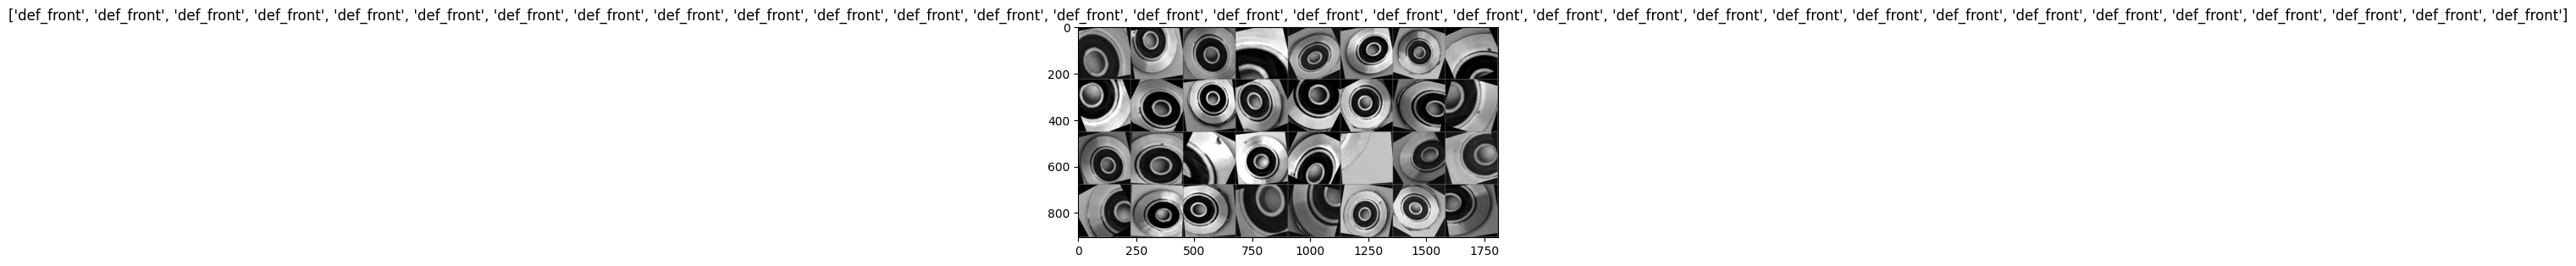

In [5]:
# Data Augmentation

# Define additional data augmentation techniques
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Reload datasets with new transformations
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

# Recreate data loaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

# Get a batch of training data with new augmentations
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Show images with new augmentations
imshow(out, title=[class_names[x] for x in classes])

In [6]:
classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

# Load Pretrained Model
Load a pretrained model from torchvision models (e.g., ResNet) for transfer learning.

In [7]:
# Load Pretrained Model

# Load a pretrained ResNet model
model_ft = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in our dataset
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model_ft = model_ft.to(device)

# Define the criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

d:\ProgramData\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgramData\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Modify the Model for Classification
Modify the final layer of the pretrained model to match the number of classes in the dataset.

In [8]:
# Modify the Model for Classification

# Load a pretrained ResNet model
model_ft = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in our dataset
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
# model_ft = model_ft.to(device)

# Define the criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Define Loss Function and Optimizer
Define the loss function (e.g., CrossEntropyLoss) and the optimizer (e.g., Adam or SGD) for training.

In [9]:
# Define Loss Function and Optimizer

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the Model
Train the model on the training data and validate it on the validation data. Track the best model based on validation accuracy.

In [10]:
# Train the Model

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # Check tensor shapes and device
                print(f'Inputs shape: {inputs.shape}, device: {inputs.device}')
                print(f'Labels shape: {labels.shape}, device: {labels.device}')

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Check outputs
                    print(f'Outputs shape: {outputs.shape}, device: {outputs.device}')

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Inputs shape: torch.Size([32, 3, 224, 224]), device: cpu
Labels shape: torch.Size([32]), device: cpu
Outputs shape: torch.Size([32, 1]), device: cpu
Inputs shape: torch.Size([32, 3, 224, 224]), device: cpu
Labels shape: torch.Size([32]), device: cpu
Outputs shape: torch.Size([32, 1]), device: cpu
Inputs shape: torch.Size([32, 3, 224, 224]), device: cpu
Labels shape: torch.Size([32]), device: cpu
Outputs shape: torch.Size([32, 1]), device: cpu
Inputs shape: torch.Size([32, 3, 224, 224]), device: cpu
Labels shape: torch.Size([32]), device: cpu
Outputs shape: torch.Size([32, 1]), device: cpu
Inputs shape: torch.Size([32, 3, 224, 224]), device: cpu
Labels shape: torch.Size([32]), device: cpu
Outputs shape: torch.Size([32, 1]), device: cpu
Inputs shape: torch.Size([32, 3, 224, 224]), device: cpu
Labels shape: torch.Size([32]), device: cpu
Outputs shape: torch.Size([32, 1]), device: cpu
Inputs shape: torch.Size([32, 3, 224, 224]), device: cpu
Labels shape: torch.Size([3

IndexError: Target 1 is out of bounds.

NameError: name 'outputs' is not defined

# Save the Best Model
Save the best model based on validation accuracy to a file.

In [ ]:
# Save the Best Model

# Save the best model based on validation accuracy to a file
best_model_path = 'best_model.pth'
torch.save(model_ft.state_dict(), best_model_path)

print(f'Best model saved to {best_model_path}')

# Apply CAM and Grad-CAM for Inference
Use Class Activation Mapping (CAM) and Gradient-weighted Class Activation Mapping (Grad-CAM) to visualize the important regions in the inference images.

In [ ]:
# Apply CAM and Grad-CAM for Inference

import torch.nn.functional as F

# Function to apply CAM
def apply_cam(model, img_tensor, target_layer):
    model.eval()
    features_blobs = []

    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())

    handle = target_layer.register_forward_hook(hook_feature)
    output = model(img_tensor.to(device))
    handle.remove()

    # Get the softmax weights
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    # Get the class index
    _, predicted = torch.max(output, 1)
    class_idx = predicted.item()

    # Get the CAM
    cam = weight_softmax[class_idx].dot(features_blobs[0].reshape((features_blobs[0].shape[1], -1)))
    cam = cam.reshape(features_blobs[0].shape[2], features_blobs[0].shape[3])
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    return cam, class_idx

# Function to apply Grad-CAM
def apply_gradcam(model, img_tensor, target_layer):
    model.eval()
    features_blobs = []
    gradients = []

    def hook_feature(module, input, output):
        features_blobs.append(output)

    def hook_gradient(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_feature = target_layer.register_forward_hook(hook_feature)
    handle_gradient = target_layer.register_backward_hook(hook_gradient)
    output = model(img_tensor.to(device))

    # Get the class index
    _, predicted = torch.max(output, 1)
    class_idx = predicted.item()

    # Backward pass
    model.zero_grad()
    class_loss = output[0, class_idx]
    class_loss.backward()

    handle_feature.remove()
    handle_gradient.remove()

    # Get the gradients and features
    grads_val = gradients[0].cpu().data.numpy().squeeze()
    target = features_blobs[0].cpu().data.numpy().squeeze()

    # Get the Grad-CAM
    weights = np.mean(grads_val, axis=(1, 2))
    grad_cam = np.zeros(target.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        grad_cam += w * target[i, :, :]
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = grad_cam - np.min(grad_cam)
    grad_cam = grad_cam / np.max(grad_cam)
    grad_cam = np.uint8(255 * grad_cam)
    return grad_cam, class_idx

# Function to visualize CAM and Grad-CAM
def visualize_cam(img_path, model, target_layer):
    img = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img).unsqueeze(0)

    cam, class_idx = apply_cam(model, img_tensor, target_layer)
    grad_cam, _ = apply_gradcam(model, img_tensor, target_layer)

    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    grad_cam = cv2.resize(grad_cam, (img.shape[1], img.shape[0]))

    heatmap_cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap_grad_cam = cv2.applyColorMap(grad_cam, cv2.COLORMAP_JET)

    result_cam = heatmap_cam * 0.4 + img * 0.6
    result_grad_cam = heatmap_grad_cam * 0.4 + img * 0.6

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'CAM - Class: {class_names[class_idx]}')
    plt.imshow(result_cam.astype(np.uint8))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Grad-CAM - Class: {class_names[class_idx]}')
    plt.imshow(result_grad_cam.astype(np.uint8))
    plt.axis('off')

    plt.show()

# Example usage
target_layer = model_ft.layer4[1].conv2
img_path = 'path_to_inference_image.jpg'
visualize_cam(img_path, model_ft, target_layer)